In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
def load_dataset(root_dir):
    """
    Load dataset from a root directory where each folder contains 3 images:
    frame1 (start), frame2 (middle), frame3 (end).
    
    Args:
        root_dir (str): Path to the root directory containing folders of images.
        
    Returns:
        list of dict: Each dict contains the paths for start, middle, and end frames.
    """
    dataset = []
    
    # Iterate over each folder in the root directory
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)
        
        # Ensure it's a directory
        if os.path.isdir(folder_path):
            # Define paths for frame1, frame2, and frame3
            frame1_path = os.path.join(folder_path, "frame1.jpg")
            frame2_path = os.path.join(folder_path, "frame2.jpg")
            frame3_path = os.path.join(folder_path, "frame3.jpg")
            
            # Check if all three frames exist
            if all(os.path.exists(path) for path in [frame1_path, frame2_path, frame3_path]):
                dataset.append({
                    "start": frame1_path,
                    "middle": frame2_path,
                    "end": frame3_path
                })
            else:
                print(f"Warning: Missing frames in {folder_path}")
    
    return dataset

In [4]:
# Constants
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0002
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class FrameDataset:
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        paths = self.image_paths[idx]
        frame1_path = paths['start']
        frame2_path = paths['middle']
        frame3_path = paths['end']
        
        # Debugging: Print the paths
        # print(f"Accessing files: {frame1_path}, {frame2_path}, {frame3_path}")
        
        # Check if files exist
        if not os.path.exists(frame1_path):
            raise FileNotFoundError(f"File not found: {frame1_path}")
        if not os.path.exists(frame2_path):
            raise FileNotFoundError(f"File not found: {frame2_path}")
        if not os.path.exists(frame3_path):
            raise FileNotFoundError(f"File not found: {frame3_path}")

        frame1 = Image.open(frame1_path)
        frame2 = Image.open(frame2_path)
        frame3 = Image.open(frame3_path)
        
        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)
        
        return frame1, frame2, frame3

    def __len__(self):
        return len(self.image_paths)

In [6]:
import torch
import torch.nn as nn

class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMGenerator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Dramatically reduce input dimensions
        self.input_layer = nn.Sequential(
            nn.Linear(input_size * 2, 1024),  # Massive reduction
            nn.ReLU(),
            nn.Dropout(0.2)  # Add dropout for regularization
        )
        
        # LSTM layer with small input size
        self.lstm = nn.LSTM(input_size=1024, hidden_size=hidden_size, batch_first=True)
        
        # Output reconstruction layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, frame1, frame3):
        # Flatten frames with reduced precision
        frame1_flat = frame1.view(frame1.size(0), -1).float()
        frame3_flat = frame3.view(frame3.size(0), -1).float()

        # Concatenate along the feature dimension
        seq_input = torch.cat([frame1_flat, frame3_flat], dim=-1)
        
        # Reduce input dimensions
        seq_input = self.input_layer(seq_input)
        
        # Reshape for LSTM input (add sequence dimension)
        seq_input = seq_input.unsqueeze(1)

        # Forward pass through LSTM
        output, _ = self.lstm(seq_input)
        predicted_frame = self.fc(output[:, -1])

        # Reshape back to image dimensions
        return predicted_frame.view_as(frame1)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
# Training Loop
def train_lstm(model, dataloader, epochs, optimizer, criterion, save_path):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        
        for i, (frame1, frame2, frame3) in enumerate(dataloader):
            # print(frame1, frame2, frame3)
            frame1, frame2, frame3 = frame1.to(DEVICE), frame2.to(DEVICE), frame3.to(DEVICE)
            
            # Forward pass
            predicted_frame2 = model(frame1, frame3)
            loss = criterion(predicted_frame2, frame2)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            # print(f"[Epoch {epoch+1}/{epochs}] [Batch {i+1}/{len(dataloader)}] [Loss: {loss.item():.4f}]")
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch + 1) % 1 == 0:
            # saving checkpoint
            torch.save(model.state_dict(), os.path.join(save_path, f"lstm_generator_epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), os.path.join(save_path, "lstm_generator.pth"))
    print(f"Model saved to {save_path}")
    
    return losses

# Plotting Loss
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(losses) + 1), losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()

In [13]:
base_dir = "C:\\Users\\Hp\\Desktop\\Semester 7\\Gen AI\\Project\\atd_12\\train_10k"
save_dir = "working/"
image_paths = load_dataset(base_dir)

In [14]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

dataset = FrameDataset(image_paths, transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize LSTM model
input_dim = IMG_SIZE * IMG_SIZE * 3  # Flattened image dimensions
hidden_dim = 32

lstm_model = LSTMGenerator(input_dim, hidden_dim, input_dim).to(DEVICE)

# Optimizer and loss function
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()


## mounting to gpu if available
lstm_model = lstm_model.to(DEVICE)
criterion = criterion.to(DEVICE)


In [ ]:
# Train model
losses = train_lstm(lstm_model, dataloader, EPOCHS, optimizer, criterion, save_dir)

Epoch 1 Average Loss: 0.0667
Epoch 2 Average Loss: 0.0631
Epoch 3 Average Loss: 0.0631
Epoch 4 Average Loss: 0.0631
Epoch 5 Average Loss: 0.0631
Epoch 6 Average Loss: 0.0631
Epoch 7 Average Loss: 0.0631
Epoch 8 Average Loss: 0.0630
Epoch 9 Average Loss: 0.0632


KeyboardInterrupt: 

In [ ]:
plot_loss(losses)

/tmp/ipykernel_23/2156361149.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load("/kaggle/working/lstm_generator_epoch_9.pth"))


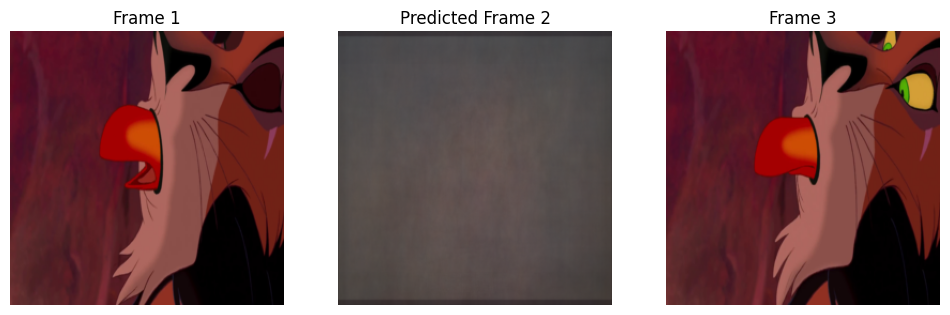

In [ ]:
lstm_model.load_state_dict(torch.load("/kaggle/working/lstm_generator_epoch_9.pth"))

# Testing
frame1 = Image.open("/kaggle/input/atd-12-dataset/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame1.png").convert("RGB")
frame3 = Image.open("/kaggle/input/atd-12-dataset/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame3.png").convert("RGB")

frame1 = transform(frame1).unsqueeze(0).to(DEVICE)
frame3 = transform(frame3).unsqueeze(0).to(DEVICE)

predicted_frame2 = lstm_model(frame1, frame3)

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(frame1[0].permute(1, 2, 0).cpu())
plt.title("Frame 1")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(predicted_frame2[0].permute(1, 2, 0).cpu().detach())
plt.title("Predicted Frame 2")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(frame3[0].permute(1, 2, 0).cpu())
plt.title("Frame 3")
plt.axis("off")

plt.show()

In [ ]:
# testing the model using MSE
# Finding the MSE score for the test dataset
def test_model(generator, dataloader):
    total_mse = 0
    total_samples = 0

    with torch.no_grad():
        for frame1, frame2, frame3 in dataloader:
            frame1, frame2, frame3 = frame1.to(DEVICE), frame2.to(DEVICE), frame3.to(DEVICE)
            gen_middle = generator(frame1, frame3)
            mse = nn.MSELoss(reduction="sum")(gen_middle, frame2)
            total_mse += mse.item()
            total_samples += frame2.numel()

    avg_mse = total_mse / total_samples
    return avg_mse

path = ''

test_image_paths = load_dataset(path)
test_dataset = FrameDataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

mse_score = test_model(lstm_model, test_dataloader)
print(f"Test MSE Score: {mse_score:.4f}")